In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pynvml
import os
pynvml.nvmlInit()
device_count = pynvml.nvmlDeviceGetCount()
device = np.argmax([pynvml.nvmlDeviceGetMemoryInfo(pynvml.nvmlDeviceGetHandleByIndex(i)).free for i in range(device_count)])
print(f'Chose GPU#{device}')
os.environ['CUDA_VISIBLE_DEVICES'] = str(device)

Chose GPU#1


In [3]:
from torch import functional as F
from torch import nn
from torchvision import datasets, transforms, models
import torch

from tqdm import notebook as tqdm
from torch.utils.tensorboard import SummaryWriter

In [4]:
from smoothing import AverageCounter, MovingAverageCounter, AdversarialAttackAugmenter, calculate_radii, get_certified_accuracies

In [5]:
def train(loader, model, criterion, optimizer, writer, epoch, augmenter, device=torch.device('cpu')):
    assert model.training
    loss_cnt = MovingAverageCounter(5)
    iteration = (epoch - 1) * len(loader.dataset)

    for X, y in tqdm.tqdm(loader):
        input = X.to(device)
        target = y.to(device).to(torch.float32)
        X_aug, y_aug = augmenter.augment_tensors(input, target, model)
        y_pred = model(X_aug)
        loss = criterion(y_pred, y_aug)
        loss_cnt.add(loss.item())
        iteration += len(y)
        writer.add_scalar('Loss/train', loss_cnt.get_average(), iteration)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(device))
else:
    device = torch.device('cpu')

NVIDIA Tesla K80


In [8]:
img_mean = [0.5063, 0.4258, 0.3832]
img_std = [0.2660, 0.2452, 0.2414]

celeba_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(32), 
    transforms.ToTensor()
])

celeba_transform_train = transforms.Compose([
    transforms.Resize(64),
    transforms.RandomCrop(32), 
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor()
])

In [9]:
celeba_train_dataset = datasets.CelebA('dsets/', split='train', target_type='attr',
                                      download=False, transform=celeba_transform_train)

In [10]:
celeba_test_dataset = datasets.CelebA('dsets/', split='valid', target_type='attr',
                                      download=False, transform=celeba_transform)

In [11]:
class CelebaModel(nn.Module):
    def __init__(self):
        super(CelebaModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.fc = nn.Linear(2048, 40)

    def forward(self, x):
        return self.resnet50(x)
    
class CelebaModel18(nn.Module):
    def __init__(self):
        super(CelebaModel18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Linear(512, 40)

    def forward(self, x):
        return self.resnet18(x)

In [12]:
cp = torch.load('cp/checkpoint.pth.tar')

In [13]:
from cifar_resnet import resnet
class NormalizeLayer(torch.nn.Module):
    """Standardize the channels of a batch of images by subtracting the dataset mean
      and dividing by the dataset standard deviation.
      In order to certify radii in original coordinates rather than standardized coordinates, we
      add the Gaussian noise _before_ standardizing, which is why we have standardization be the first
      layer of the classifier rather than as a part of preprocessing as is typical.
      """

    def __init__(self, means, sds):
        """
        :param means: the channel means
        :param sds: the channel standard deviations
        """
        super(NormalizeLayer, self).__init__()
        self.means = torch.tensor(means).to(device)
        self.sds = torch.tensor(sds).to(device)

    def forward(self, input):
        means = self.means.view(1, 3, 1, 1).expand_as(input)
        sds = self.sds.view(1,3,1,1).expand_as(input)
        return (input - means)/sds

In [14]:
model = nn.Sequential(NormalizeLayer(img_mean, img_std), resnet(depth=110, num_classes=1000))
model.load_state_dict(cp['state_dict'])
model[1].fc = nn.Linear(64, 40)
model = model.to(device)

In [15]:
batch_size=64

In [16]:
train_loader = torch.utils.data.DataLoader(celeba_train_dataset, batch_size)
test_loader = torch.utils.data.DataLoader(celeba_test_dataset, batch_size)

In [17]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model[1].parameters(), lr=1e-3)
augmenter = AdversarialAttackAugmenter(4, 4.0, 2, 1)

In [18]:
writer = SummaryWriter(log_dir='runs/celeba-adv-pretrained')

In [19]:
def uncertified_validate(loader, model, criterion, writer, epoch, device):
    assert model.training
    try:
        model.eval()
        loss_cnt = AverageCounter()
        accuracy_cnt = AverageCounter()
        with torch.no_grad():
            for X, y in tqdm.tqdm(loader):
                y_pred = model(X.to(device))
                y = y.to(device)
                accuracy_cnt.add(torch.mean(((y_pred > 0) == y).to(torch.float)).item())
                loss = criterion(y_pred, y.to(y_pred.dtype))
                loss_cnt.add(loss.item())
            writer.add_scalar('Loss/val', loss_cnt.get_average(), epoch)
            writer.add_scalar('Accuracy/val', accuracy_cnt.get_average(), epoch)
    finally:
        model.train()

Epoch 2


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

NameError: name 'pl' is not defined

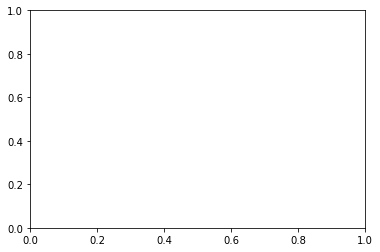

In [20]:
epoch = 2
while epoch <= 10:
    print(f'Epoch {epoch}')
    model.train()
    train(train_loader, model, criterion, optimizer, writer, epoch, augmenter, device)
    torch.save(model, f'celeba-pt-adv{epoch:02d}.pth')
    uncertified_validate(test_loader, model, criterion, writer, epoch, device)
    res = calculate_radii(celeba_test_dataset, range(25), model, 10**2, 10**4, 1e-3, 1., device=device, batch_size=batch_size)
    torch.save(res, f'adv-pt-res{epoch:02d}.pth')
    fig, ax = plt.subplots()
    pl(ax, res, label='50')
    pl(ax, torch.load('adv-big-res11.225.pth'), label='50')
    ax.axhline(0.818, label='constant', c='k')
    ax.legend()
    writer.add_figure('certified-accuracy', fig, epoch)
    epoch += 1

In [ ]:
uncertified_validate(test_loader, model, criterion, writer, epoch, device)

In [ ]:
res_50 = calculate_radii(celeba_test_dataset, range(25), model, 10**2, 10**4, 1e-3, 1., device=device, batch_size=batch_size)

In [ ]:
torch.save(res_50, 'adv-big-res01.pth')

In [ ]:
res_10_old = res_10

In [ ]:
res_10 = calculate_radii(celeba_test_dataset, range(25), torch.load('celeba10.pth').to(device), 10**2, 10**4, 1e-3, 1., device=device, batch_size=batch_size)

In [ ]:
torch.save(res_10, 'eval10.pth')

In [ ]:
def get_certified_accuracies(d):
    from smoothing import certified_accuracy
    radii = np.linspace(0, d['r'].view(-1).max())
    res = np.zeros_like(radii)
    for i, r in enumerate(radii):
        res[i] = certified_accuracy(d['y_pred'].view(-1), d['r'].view(-1), d['y'].view(-1), r)
    return radii, res

In [ ]:
def pl(ax, d, **kwargs):
    radii, res = get_certified_accuracies(d)
    ax.plot(radii, res, **kwargs)

In [ ]:
fig, ax = plt.subplots()
pl(ax, torch.load('adv-big-res01.pth'), label='50')
pl(ax, res_10, label='smoothened')

ax.legend()

In [ ]:
(res_50['y_pred'] == res_50['y']).view(-1).to(torch.float).mean()

In [ ]:
d = torch.load('eval10.pth')

In [ ]:
radii_old = np.linspace(0, d['r'].view(-1).max())
res_old = np.zeros_like(radii_old)
for i, r in enumerate(radii_old):
    res_old[i] += certified_accuracy(d['y_pred'].view(-1), d['r'].view(-1), d['y'].view(-1), r)

In [ ]:
from statsmodels.stats.proportion import proportion_confint

In [ ]:
N = 10**6
est_lo, est_hi = proportion_confint(N, N, 2e-3, method='beta')

In [ ]:
from scipy.stats import norm, binom_test

In [ ]:
norm.ppf(est_lo)